In [ ]:

    def compute_transition_energy(self, t_final=10.0, N=50):
        """
        Solve a simple OCP for the transition from hover (V=0, h=0) to (V=V_cruise, h=h_cruise)
        over t_final seconds, using N intervals, including explicit theta, gamma, lift, drag,
        and separate thrust components Tv (vertical) and Tf (forward).
        
        Returns:
            E_wh (float): total electrical energy consumed [Wh]
            P_peak (float): peak electrical power [W]
            traj (dict): time-series of states and controls
        """
        m = self.drone.MTOW                    # mass [kg]
        eta = self.drone.propulsion.η_elec * self.drone.propulsion.η_prop  # overall efficiency
        S = self.drone.wing.S                 # wing area [m^2]
        # lift slope (approx)
        CL_alpha = self.drone.wing.CLalpha(0) # per-rad at low Mach, Update with real Mach number
        Cd = self.drone.aero.CD               # drag coefficient
        
        V_cruise = toml["config"]["mission"]["cruise_speed"]
        h_cruise = toml["config"]["mission"]["cruise_height"]
        
        opti = ca.Opti()
        # decision vars
        V   = opti.variable(N+1)       # speed
        gamma = opti.variable(N+1)     # flight path angle [rad]
        y   = opti.variable(N+1)       # altitude [m]
        Eb  = opti.variable(N+1)       # battery energy [J]
        theta = opti.variable(N+1)     # body pitch angle [rad]
        
        Tv  = opti.variable(N)         # vertical thrust [N]
        Tf  = opti.variable(N)         # forward thrust [N]
        delta = 0                      # assume no tilt relative to body
        
        dt = t_final / N
        
        # dynamics and track energy, power
        E_traj = []
        P_traj = []
        for k in range(N):
            # states at k
            V_k = V[k]
            gamma_k = gamma[k]
            y_k = y[k]
            Eb_k = Eb[k]
            theta_k = theta[k]
            # controls
            Tv_k = Tv[k]
            Tf_k = Tf[k]
            # aerodynamic forces
            D = 0.5 * ρ * Cd * self.drone.wing.S * V_k**2
            CL = CL_alpha * (theta_k - gamma_k)  # effective AoA ~ theta-gamma
            L = 0.5 * ρ * CL * self.drone.wing.S * V_k**2
            # thrust components in body axis
            alpha_t = theta_k + delta - gamma_k
            # speed and flight path dynamics
            dV = (Tv_k * ca.sin(alpha_t) + Tf_k * ca.cos(alpha_t) - D - m*g*ca.sin(gamma_k)) / m
            dgamma = (Tv_k * ca.cos(alpha_t) - Tf_k * ca.sin(alpha_t) + L - m*g*ca.cos(gamma_k)) / (m * V_k + 1e-6)
            # altitude derivative
            dy = V_k * ca.sin(gamma_k)
            # power consumption
            Pelec = (Tv_k * dy + Tf_k * V_k) / eta
            dEb = -Pelec
            # Euler integration
            opti.subject_to(V[k+1]   == V_k   + dt * dV)
            opti.subject_to(gamma[k+1] == gamma_k + dt * dgamma)
            opti.subject_to(y[k+1]   == y_k   + dt * dy)
            opti.subject_to(Eb[k+1]  == Eb_k  + dt * dEb)
            # record symbolic energy/power
            E_traj.append(-dEb * dt)       # J
            P_traj.append(Pelec)           # W


        # # Linearly interpolate V from 0 to V_cruise
        # V_init = np.linspace(0, V_cruise, N+1)
        # opti.set_initial(V, ca.DM(V_init))

        # # Altitude from 0 to h_cruise
        # y_init = np.linspace(0, h_cruise, N+1)
        # opti.set_initial(y, ca.DM(y_init))

        # # Flight-path angle near zero (small climb angle)
        # opti.set_initial(gamma, ca.DM(0.05))

        # # Battery starts full
        # opti.set_initial(Eb, ca.DM(4000*1000)) # 4000 kJ, adjust as needed

        # # Pitch angle: assume theta ~ gamma
        # opti.set_initial(theta, ca.DM(gamma))
        
        # Thrust: approximate hover thrust then cruise thrust
        # hover_T = self.drone.MTOW * 9.81
        # Tf_hover = 0.0
        # Tf_cruise = 0.5 * hover_T  # rough guess
        # Tv_guess = np.linspace(hover_T, hover_T*0.2, N)
        # Tf_guess = np.linspace(Tf_hover, Tf_cruise, N)
        # opti.set_initial(Tv, ca.DM(Tv_guess))
        # opti.set_initial(Tf, ca.DM(Tf_guess))
        
        # warm start
        V_init   = np.linspace(0, V_cruise, N+1)
        Tv_init  = np.linspace(m*g, m*g*0.2, N)
        Tf_init  = np.linspace(0, m*g*0.5, N)
        gamma_init = np.linspace(0, 0, N+1)
        y_init     = np.linspace(0, h_cruise, N+1)
        Eb_init    = np.ones(N+1) * 4000 * 1000  # 4000 kJ, adjust as needed
        theta_init = gamma_init

        opti.set_initial(V,     V_init)
        opti.set_initial(Tv,    Tv_init)
        opti.set_initial(Tf,    Tf_init)
        opti.set_initial(gamma, gamma_init)
        opti.set_initial(y,     y_init)
        opti.set_initial(Eb,    Eb_init)
        opti.set_initial(theta, theta_init)
        
        # boundary conditions
        opti.subject_to(V[0]    == 0)
        opti.subject_to(y[0]    == 0)
        opti.subject_to(gamma[0]== 0)
        opti.subject_to(V[-1]   == V_cruise)
        opti.subject_to(y[-1]   == h_cruise)
        opti.subject_to(gamma[-1]== 0)
        # thrust limits
        Tmax = self.drone.propulsion.motor.max_thrust()  # max thrust [N]
        opti.subject_to(Tv >= 0)
        opti.subject_to(Tf >= 0)
        opti.subject_to(Tv + Tf <= Tmax)
        # minimize energy
        cost = sum(P_traj) * dt
        opti.minimize(cost)
        
        # solve
        opti.solver(
        'ipopt',
        {"print_time": False, "tol": 1e-3, "acceptable_tol": 1e-2},
        {"max_iter": 5000, "acceptable_iter": 3000}
        )
        try:
            sol = opti.solve()
            # extract results
            t_grid = np.linspace(0, t_final, N+1)
            traj = {
                't'     : t_grid,
                'V'     : sol.value(V),
                'gamma' : sol.value(gamma),
                'y'     : sol.value(y),
                'theta' : sol.value(theta),
                'Tv'    : sol.value(Tv),
                'Tf'    : sol.value(Tf),
                'P'     : np.array([sol.value(p) for p in P_traj]),
            }
            E_wh   = float(sum(sol.value(E_traj)) / 3600)  # Wh
            P_peak = float(max(traj['P']))
        
        except RuntimeError:
            print("=== Debug Values ===")
            print("V:", opti.debug.value(V))
            print("Tv:", opti.debug.value(Tv))
            # etc.
            raise
        
        return E_wh, P_peak, traj

In [ ]:
mission = Mission("DRCCRCCRCCD")
drone = Drone()
perf = Performance(drone, mission)
drone.perf = perf
drone.class_1_weight_estimate()

drone.wing.S = perf.wing_area(drone.OEW)

drone.class_2_weight_estimate()

drone.iterative_weight_estimate(plot=True, tolerance=0.01)

results = []
for T in [50, 80, 120, 200]:
    try:
        E, Pmax, traj = drone.perf.compute_transition_energy(t_final=T, N=20)
        results.append((T, E, Pmax))
        t = traj['t']
        fig, axs = plt.subplots(3, 2, figsize=(14, 12))

        # Speed
        axs[0, 0].plot(t, traj['V'])
        axs[0, 0].set_title('Speed (V) [m/s]')
        axs[0, 0].set_xlabel('Time [s]')
        axs[0, 0].set_ylabel('V [m/s]')

        # Altitude
        axs[0, 1].plot(t, traj['y'])
        axs[0, 1].set_title('Altitude (y) [m]')
        axs[0, 1].set_xlabel('Time [s]')
        axs[0, 1].set_ylabel('Altitude [m]')

        # Flight path angle
        axs[1, 0].plot(t, traj['gamma'] * 180/np.pi)
        axs[1, 0].set_title('Flight Path Angle (gamma) [deg]')
        axs[1, 0].set_xlabel('Time [s]')
        axs[1, 0].set_ylabel('gamma [deg]')

        # Pitch angle
        axs[1, 1].plot(t, traj['theta'] * 180/np.pi)
        axs[1, 1].set_title('Pitch Angle (theta) [deg]')
        axs[1, 1].set_xlabel('Time [s]')
        axs[1, 1].set_ylabel('theta [deg]')

        # Thrusts
        axs[2, 0].plot(t[:-1], traj['Tv'], label='Vertical Thrust')
        axs[2, 0].plot(t[:-1], traj['Tf'], label='Forward Thrust')
        axs[2, 0].set_title('Thrusts [N]')
        axs[2, 0].set_xlabel('Time [s]')
        axs[2, 0].set_ylabel('Thrust [N]')
        axs[2, 0].legend()

        # Power
        axs[2, 1].plot(t[:-1], traj['P'])
        axs[2, 1].set_title('Electrical Power [W]')
        axs[2, 1].set_xlabel('Time [s]')
        axs[2, 1].set_ylabel('Power [W]')

        plt.tight_layout()
        plt.show()
    except RuntimeError as e:
        logging.info(f"  → Solver failed for T={T:.1f}s: {e}")
        results.append((T, None, None))

Text(0.5, 1.0, 'Noise Level vs Height')

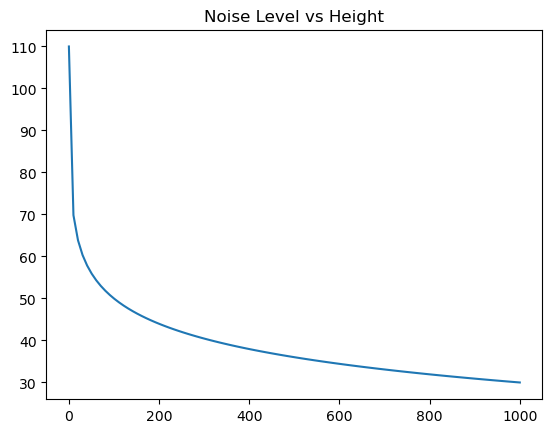

In [6]:
import numpy as np
import matplotlib.pyplot as plt
Noise_level = 90 # dBA at 1 m distance
h = np.linspace(0.1, 1000, 100)  # Height in meters
n = 10*np.log10(10**(Noise_level/10)/h**2)

plt.plot(h, n)
plt.title('Noise Level vs Height')
plt.xlabel('Height (m)')
plt.ylabel('Noise Level (dBA)')
plt.grid()
